In [1]:
import pandas as pd
from pathlib import Path
from plots.loader import get_subfolders, load_multiple_timings

folders = get_subfolders(Path("measurements/af_shell10/compare_comb"))
# Returns the matrix name and a dictionary of mapping from function to dataframe
matrix, ft = load_multiple_timings(folders)

In [2]:
ft['comb']

,func,duration,bytes,node_id,nodes,mpi
0,gemm,5.379230e+08,0,15,16,16
1,gemm,5.398420e+08,0,15,16,16
2,gemm,5.388120e+08,0,15,16,16
3,gemm,5.389030e+08,0,15,16,16
4,gemm,5.372570e+08,0,15,16,16
...,...,...,...,...,...,...
46,bytes,0.000000e+00,0,195,196,196
47,bytes,0.000000e+00,0,195,196,196
48,bytes,0.000000e+00,0,195,196,196
49,bytes,0.000000e+00,0,195,196,196


In [3]:
ft['drop_at_once_parallel']

,func,duration,bytes,node_id,nodes,mpi
0,triplets_to_map,373919000.0,0,15,16,16
1,triplets_to_map,342025000.0,0,15,16,16
0,gemm,102664000.0,0,15,16,16
1,gemm,100512000.0,0,15,16,16
2,gemm,108495000.0,0,15,16,16
...,...,...,...,...,...,...
377,build_csr,132986.0,0,195,196,196
378,build_csr,126100.0,0,195,196,196
379,build_csr,137582.0,0,195,196,196
380,build_csr,130442.0,0,195,196,196


In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# SCALING_FACTOR = 10**9 # for seconds
SCALING_FACTOR = 10**6
plt.rcParams['font.family'] = 'Computer Modern Roman'
plt.rcParams['text.usetex'] = True

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
STYLES = {
    # color, marker, offst, name
    "comb": ('deeppink', 'D', (-80, -40), "\\textsc{CombBLAS}", None),
    "drop_at_once_parallel": ('dodgerblue', 'o', (-50, -20), "\\textsc{DropAtOnceNS}", None),
    "drop_parallel": ('goldenrod', 'h', (-60, -20), "\\textsc{NHWC}", None),
    # "todo3": ('brown', '^', (-210, -135), "\\textsc{Tensor Macro}", 26),
    # "todo4": ('darkcyan', 'H', (-75, -15), "\\textsc{Merged}", None),
    # "todo5": ('darkolivegreen', 's', (-120, -118), "\\textsc{Merged+Blocked}", None),
}

/tmp/ipykernel_1119833/1005327138.py:39: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar([keysm[key] for key in timings["key"]], values, yerr=eb, fmt='-o', label=algo, marker=marker, color=color)
/tmp/ipykernel_1119833/1005327138.py:39: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar([keysm[key] for key in timings["key"]], values, yerr=eb, fmt='-o', label=algo, marker=marker, color=color)


Text(0.5, 1.0, 'Squaring computation on \\texttt{af_shell10}')

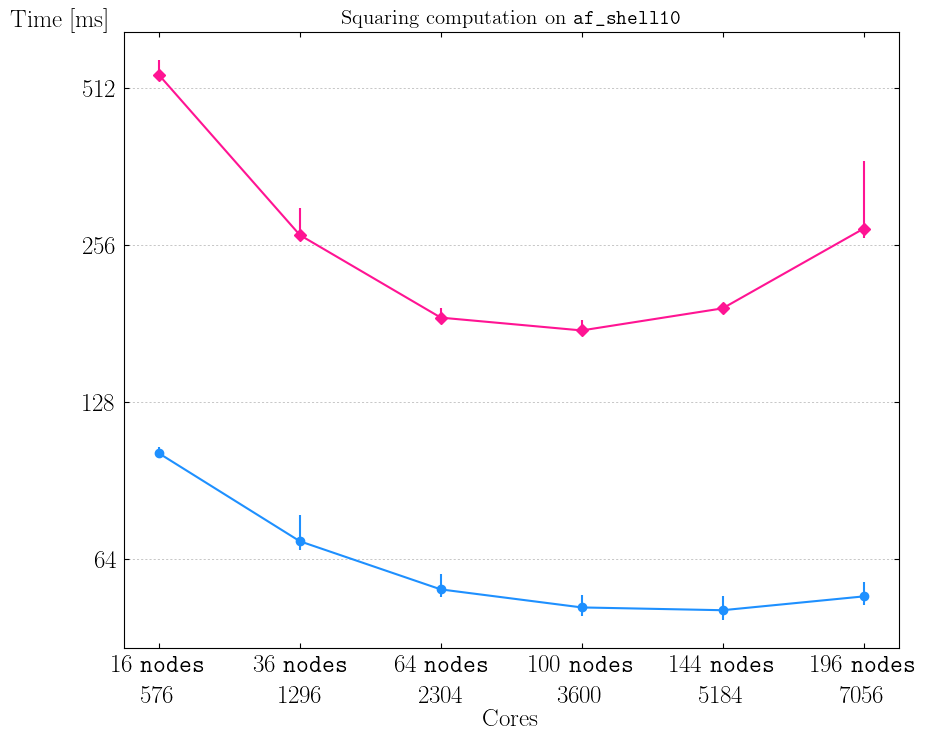

In [5]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

keysm = {}
keysm[16] = 0
keysm[36] = 1
keysm[64] = 2
keysm[100] = 3
keysm[144] = 4
keysm[196] = 5

for algo, pretty_name in (('comb', 'ComBLAS'), ('drop_at_once_parallel', 'DropAtOnceParallel')):
    timings = ft[algo]
    func_data = timings[timings["func"] == 'gemm']

    timings = []
    for key, group in func_data.groupby('mpi'):
        value = group["duration"]
        avg = value.mean()/SCALING_FACTOR
        timings.append({
            "key": key,
            "avg": avg,
            "min": min(value.quantile(0.025)/SCALING_FACTOR, avg),
            "max": max(value.quantile(0.975)/SCALING_FACTOR, avg)
        })

    timings = pd.DataFrame(timings)
    # Calculate the error bars
    eb = [
        (timings['avg'] - timings['min']),
        (timings['max'] - timings['avg'])
    ]

    color, marker, offst, name, rotation = STYLES[algo]

    keys = timings["key"]
    values = timings["avg"]
    ax.annotate(name, (keys.iloc[-1], values.iloc[-1]), color=color, xytext=offst, textcoords='offset points', fontsize='x-large', rotation=rotation or 0)
    ax.errorbar([keysm[key] for key in timings["key"]], values, yerr=eb, fmt='-o', label=algo, marker=marker, color=color)

    ax.set_xlabel("Cores")
    ax.set_ylabel('Time [ms]',
            rotation='horizontal',
            loc='top',
            labelpad=-20)
    ax.set_xticks(range(len(keys)), labels=[f"\\begin{{center}}{mpi}~\\texttt{{nodes}}\\\\{mpi * 36}\\end{{center}}"for mpi in keys])

ax.tick_params(axis='both', direction='in', which='major', pad=5)
ax.grid(which='major', axis='y', linewidth=.5, dashes=(3,3))
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.yscale('log', base=2)
from matplotlib.ticker import FuncFormatter
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}'))

ax.set_title("Squaring computation on \\texttt{" + matrix + "}", fontsize=15)